In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

In [3]:
def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

In [4]:
def closest(plasma, lim):
    min = 1E10
    point = [0,0]
    for i in range(np.size(lim[:,0])):
        distances = np.sqrt((plasma[:,0]-lim[i,0])**2 +(plasma[:,1]-lim[i,1])**2 )
        if np.min(distances)<min:
            min = np.min(distances)
            point = plasma[np.argmin(distances),:]
    return point, min*100

In [5]:
r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/0.85, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))
vv1 = resize_polygon(lim1, 0.03)

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.03)

lim3 = resize_polygon(lim1, -0.1)
vv3 = resize_polygon(lim3, 0.03)

In [6]:
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': .9, 'zc': 0.7, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1.15, 'zc': 0.65, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.25, 'zc': 0.45, 'w': 0.1, 'h': 0.1},
    'EF4U': {'rc': 1.7, 'zc': 0.4, 'w': .15, 'h': .15},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': .9, 'zc': -0.7, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1.15, 'zc': -0.65, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.25, 'zc': -0.45, 'w': 0.1, 'h': 0.1},
    'EF4L': {'rc': 1.7, 'zc': -0.4, 'w': .15, 'h': .15},
  
}

In [7]:
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': .85, 'zc': 0.7, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1.1, 'zc': 0.7, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.3, 'zc': 0.5, 'w': 0.1, 'h': 0.1},
    'EF4U': {'rc': 1.7, 'zc': 0.4, 'w': .15, 'h': .15},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': .85, 'zc': -0.7, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1.1, 'zc': -0.7, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.3, 'zc': -0.5, 'w': 0.1, 'h': 0.1},
    'EF4L': {'rc': 1.7, 'zc': -0.4, 'w': .15, 'h': .15},
  
}

In [8]:
## Define mesh resolution in each region
plasma_resolution = 0.02
coil_resolution = 0.02
vv_resolution = 0.03
vac_resolution = 0.075

In [11]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1e-6)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [12]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

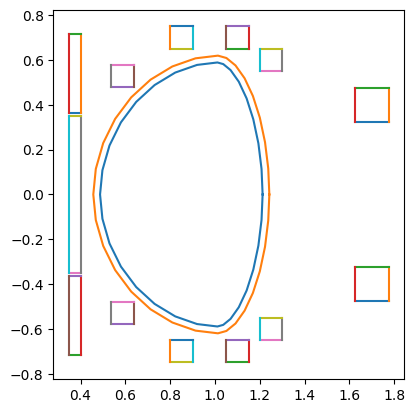

In [13]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [14]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 728
  # of unique segments  = 58
Generating mesh:
  # of points  = 4616
  # of cells   = 9126
  # of regions = 16


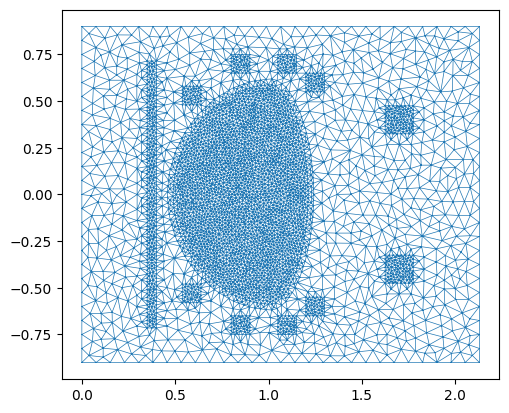

In [15]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

In [16]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.85*3) ## F0 = R0 * B0

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.834E+00
    # of points  =    4616
    # of edges   =   13741
    # of cells   =    9126
    # of boundary points =     104
    # of boundary edges  =     104
    # of boundary cells  =     104
  Resolution statistics:
    hmin =  1.242E-02
    hrms =  3.323E-02
    hmax =  1.106

In [17]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,8] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,9] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,10] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,11] = -1
coil_reg_mat[7,7] = 1
coil_reg_mat[7,12] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)


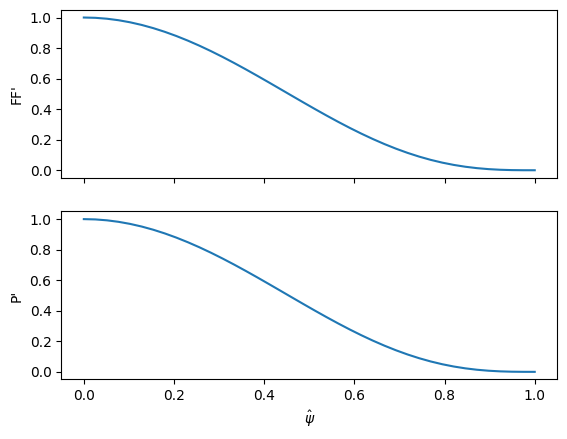

In [18]:
# Define shape of P' anf FF' profiles

n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [19]:
#Define global quantities
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1) #Can change poloidal beta by modifying Ip_ratio target

In [23]:
##Set shape targets
kappa = 1.9
delta = -0.5

r, z, zeff = boundaryShape(kapu = kappa, kapl = kappa, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
isoflux_weights = 10*np.ones(32)
mygs.set_isoflux(boundary, isoflux_weights)

#Set saddle targets
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)



In [24]:
mygs.init_psi(0.8,0,0.22, kappa,delta) #Initial "guess"
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  7.7521E+00  5.1263E+00  4.0636E-02  8.8490E-01  5.2251E-06 -0.0000E+00
     2  9.2174E+00  6.0671E+00  1.6413E-02  8.8641E-01  1.3703E-05 -0.0000E+00
     3  9.9724E+00  6.5534E+00  6.9197E-03  8.8715E-01  1.8608E-05 -0.0000E+00
     4  1.0428E+01  6.8477E+00  3.3845E-03  8.8754E-01  2.1659E-05 -0.0000E+00
     5  1.0709E+01  7.0305E+00  1.8363E-03  8.8774E-01  2.4104E-05 -0.0000E+00
     6  1.0883E+01  7.1439E+00  1.0512E-03  8.8784E-01  2.5617E-05 -0.0000E+00
     7  1.0990E+01  7.2141E+00  6.1749E-04  8.8789E-01  2.6598E-05 -0.0000E+00
     8  1.1056E+01  7.2574E+00  3.6746E-04  8.8792E-01  2.7387E-05 -0.0000E+00
     9  1.1097E+01  7.2840E+00  2.2008E-04  8.8793E-01  2.8052E-05 -0.0000E+00
    10  1.1121E+01  7.3003E+00  1.3268E-04  8.8793E-01  2.8627E-05 -0.0000E+00
    11  1.1137E+01  7.3106E+00  8.0515E-05  8.8793E-01  2.9114E-05 -0.0000E+00
    12  1.1146E+01  7.3165E+00  4.7595E-05  8.8793E-01  2.9515E-05 -0.0000E+00
    13  1.1151E+01  7.

0

[ 0.94969153 -0.50401404]
[0.95002523 0.50437052]
[ 0.98395997 -0.48991447]
[0.98373514 0.48776518]
bye
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    0.877  0.000
  Magnetic Axis [m]       =    0.888  0.000
  Elongation              =    1.838 (U:  1.938, L:  1.738)
  Triangularity           =   -0.439 (U: -0.522, L: -0.356)
  Plasma Volume [m^3]     =    1.785
  q_0, q_95               =    0.560  2.195
  Peak Pressure [Pa]      =    4.2401E+05
  Stored Energy [J]       =    1.9385E+05
  <Beta_pol> [%]          =   53.0251
  <Beta_tor> [%]          =    2.1510
  Diamagnetic flux [Wb]   =    9.8596E-03
  Toroidal flux [Wb]      =    9.8889E-01
  l_i                     =    1.2421


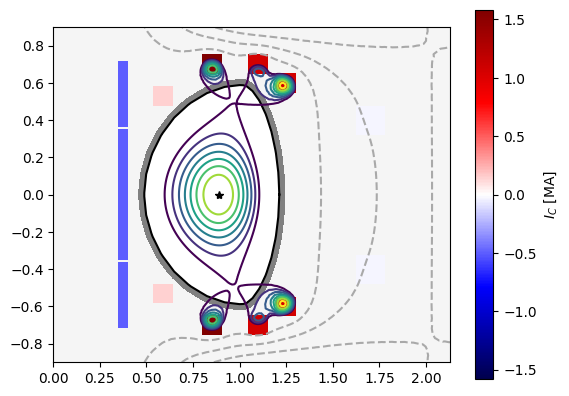

In [25]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
#mygs.plot_constraints(fig,ax)
mygs.print_info()

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.834E+00
    # of points  =    4620
    # of edges   =   13753
    # of cells   =    9134
    # of boundary points =     104
    # of boundary edges  =     104
    # of boundary cells  =     104
  Resolution statistics:
    hmin =  1.242E-02
    hrms =  3.315E-02
    hmax =  1.171

 "none"
Flux surfaces from 600x600 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.0025365011216131003 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:01.728795
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:00.998311
Flux surface averaging ...
  > Took 0:00:01.259496
Geometric quantities ...
  > Took 0:00:02.884830
[0.92732784 0.38705837]
[ 0.92731228 -0.3870452 ]
hi
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#-

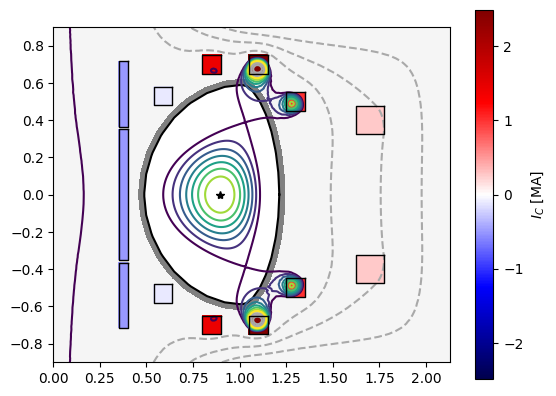

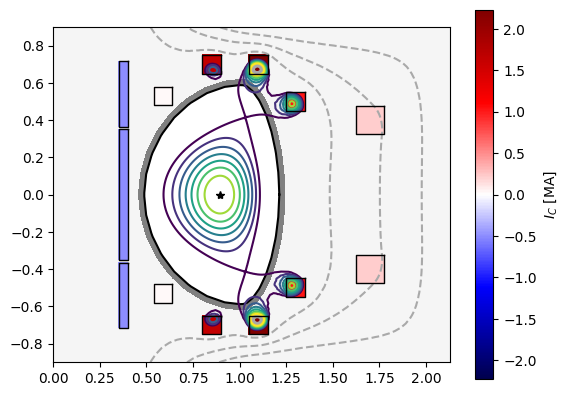

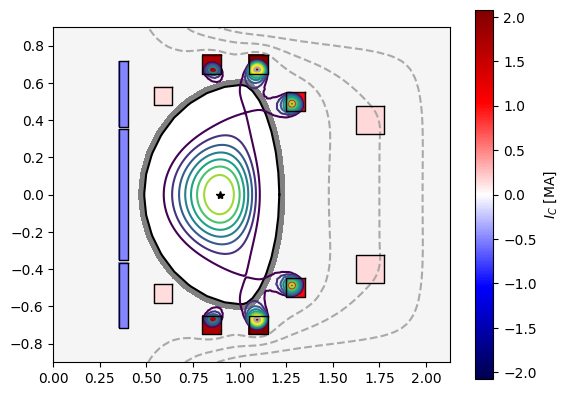

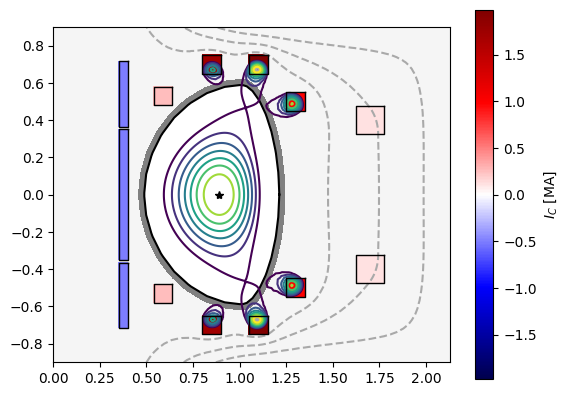

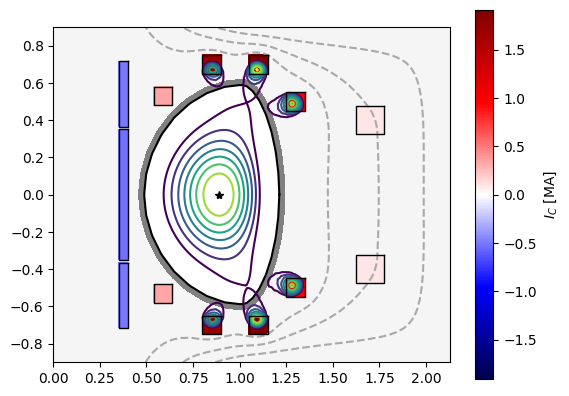

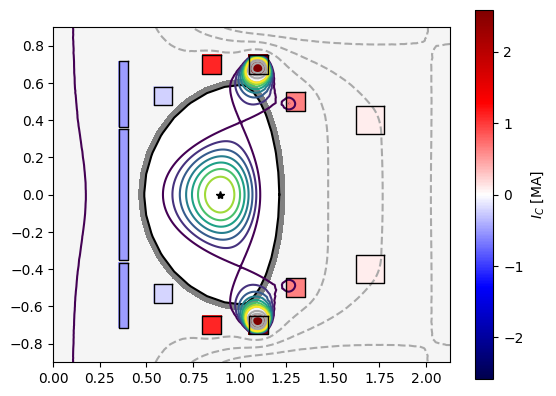

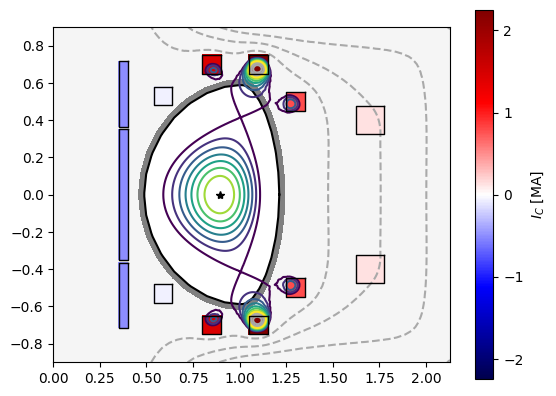

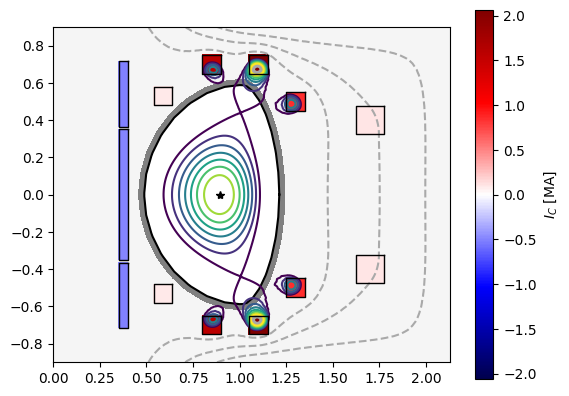

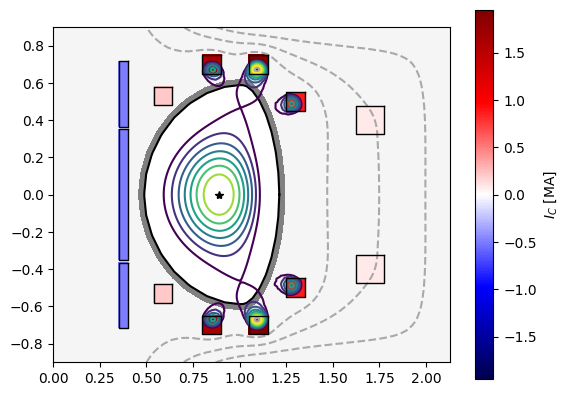

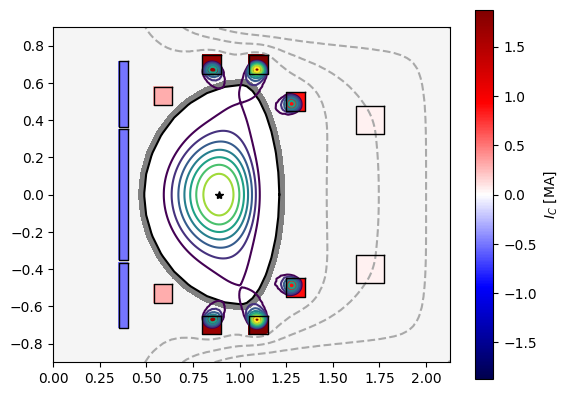

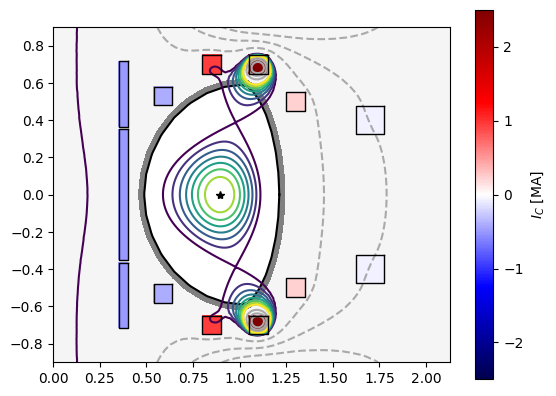

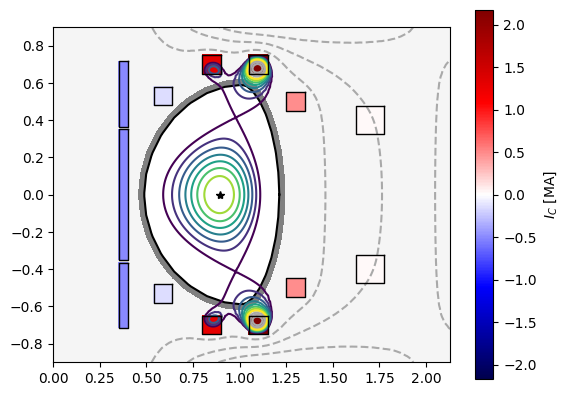

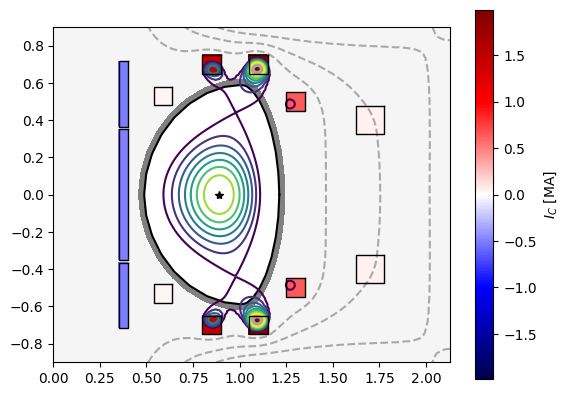

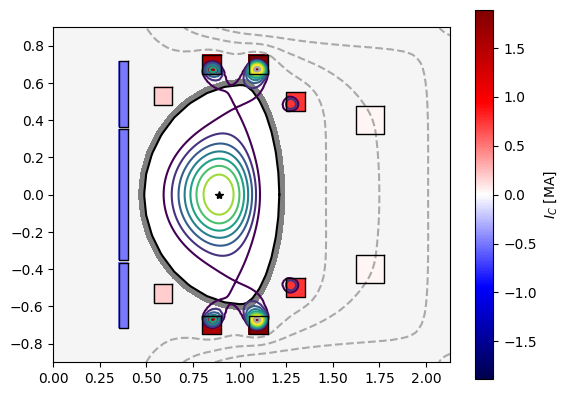

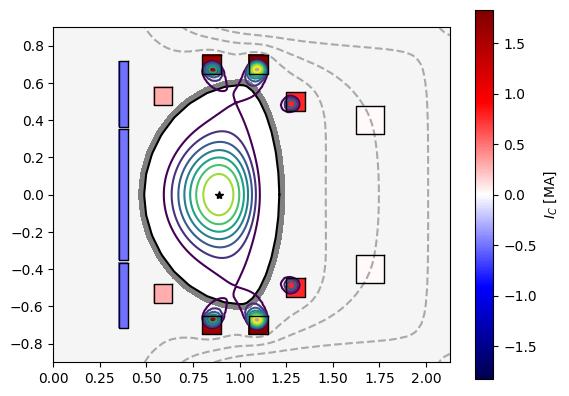

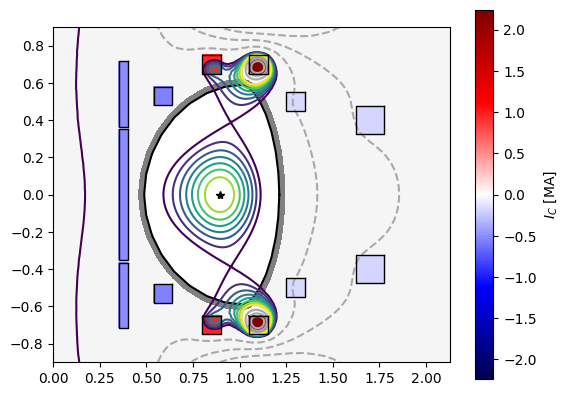

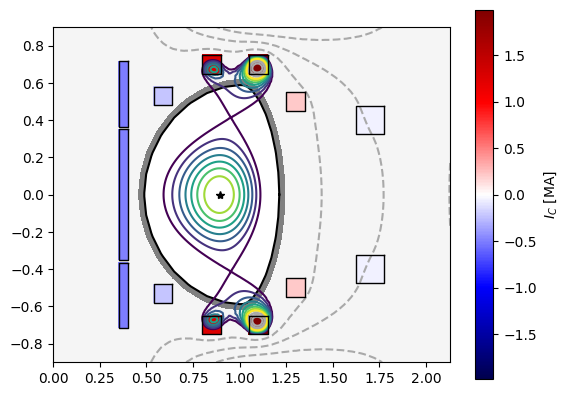

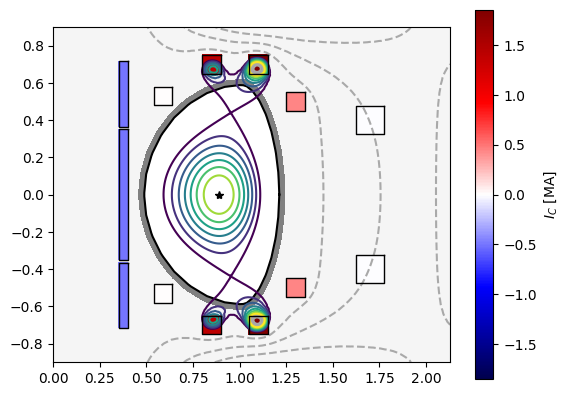

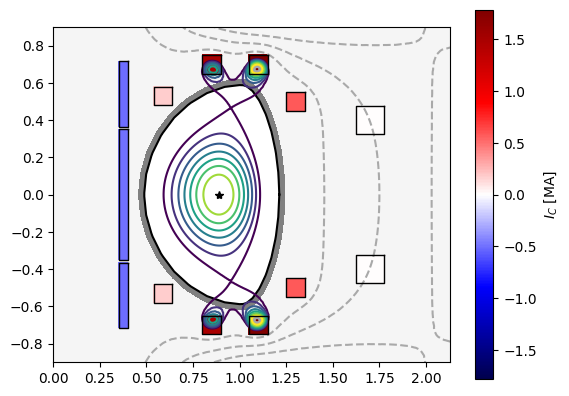

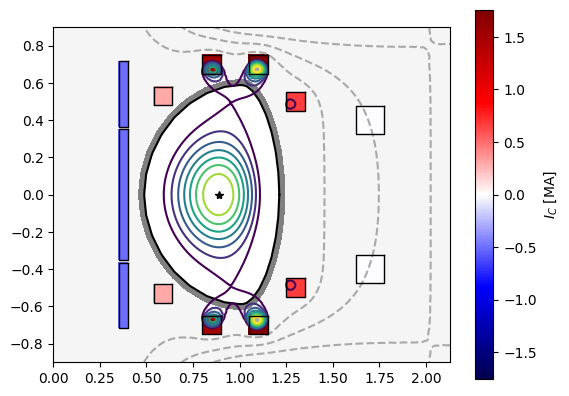

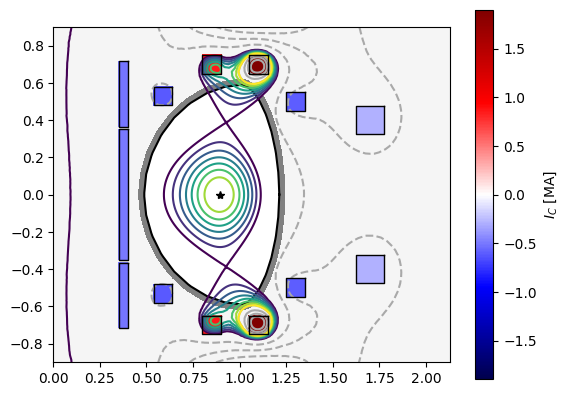

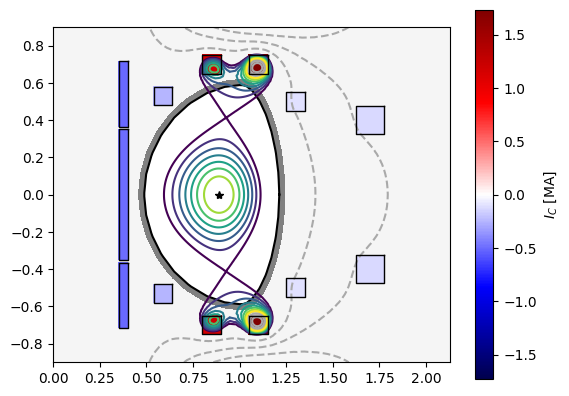

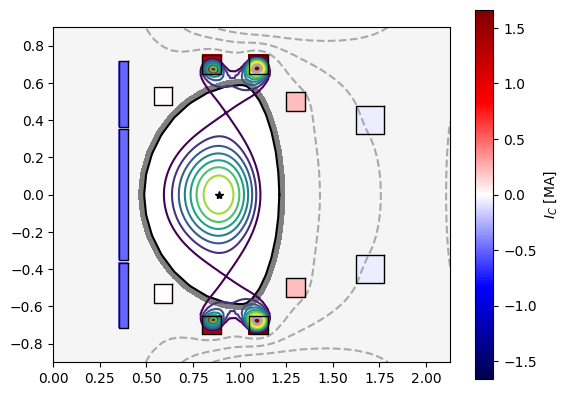

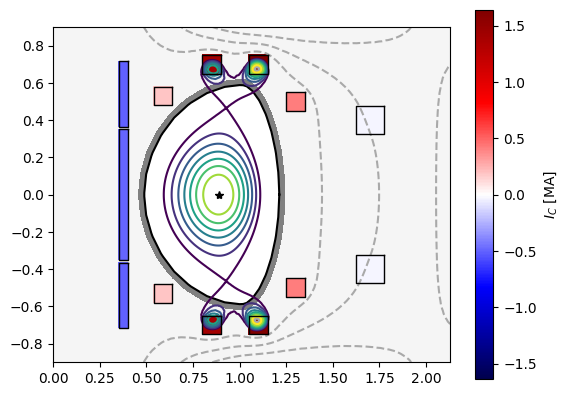

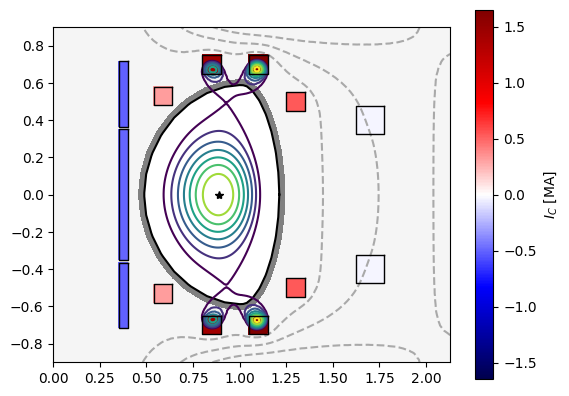

In [14]:
import copy
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
d_omfit = []
e_omfit = []
d_tok = []
e_tok = []
q95 = []
betap = []
li = []
coil_currents = []
ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)
dist = []
gammas = []
taus = []
eqdsks = []
lcfs = []

for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[2,2] = 1
        targets[0] = -5E5
        targets[1] = -5E5 
        targets[2] = -5E5

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,8] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,9] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,10] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,11] = -1
        coil_reg_mat[7,7] = 1
        coil_reg_mat[7,12] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
        # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        # set boundary/saddle point targets
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 5*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 10*np.ones(32)

        if d < -0.65 and e > 1.85:
            isoflux_weights = 30*np.ones(32)
            print('catch')
        
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        #plot equilibrium
        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
        for key, coil in coils.items():
            plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

        #save as eqdsk
        mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)

        eqdsk = OMFITgeqdsk('temp')
        d_omfit.append(eqdsk['fluxSurfaces']['geo']['delta'][-1])    
        e_omfit.append(eqdsk['fluxSurfaces']['geo']['kap'][-1])
        
        point, distance = closest(read_eqdsk('temp')['rzout'], lim2)
        dist.append(distance)

        lcfs.append(read_eqdsk('temp')['rzout'])
        stats = mygs.get_stats()
        q95.append(stats['q_95'])
        betap.append(stats['beta_pol'])
        li.append(stats['l_i'])
        d_tok.append(stats['delta'])
        e_tok.append(stats['kappa'])

        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
        gammas.append(eig_vals[0,0])

        eig_wall, eigvec_wall = mygs.eig_wall()
        taus.append(1/eig_wall[1][0])

        #extract coil currents
        current,currentmap = mygs.get_coil_currents()
        coil_currents.append(current)
        

        mygs.reset()

In [16]:
print(d_omfit)

[-0.6875499182338727, -0.6938743479132314, -0.6873299747370408, -0.6933286644903405, -0.710863156579997, -0.5906439573888362, -0.5914641757591488, -0.5898891394611642, -0.5908934828534145, -0.5842658397824501, -0.48832272862701664, -0.4896969920167138, -0.49045851704503507, -0.4940624946384931, -0.49281439348459066, -0.38340419320999786, -0.38529984464369943, -0.3928752056741427, -0.38948773823510274, -0.3933100941607175, -0.2834395877399999, -0.2855661290705789, -0.28818868274755743, -0.28847979391889494, -0.29641712281661203]


In [19]:
print(e_omfit)

[1.488677136343963, 1.597590685935132, 1.6972687719058313, 1.8042216893753158, 1.9000422185513726, 1.4808635724438892, 1.5884816311588275, 1.6932376836506091, 1.7964536877390735, 1.896584302309242, 1.477100144210923, 1.580838465510709, 1.6866670888915, 1.7974416692899076, 1.9000559597447226, 1.4802471133413595, 1.5844532082810696, 1.6904413930401385, 1.7878188905335952, 1.8946957089195349, 1.4873717731116822, 1.590177554703145, 1.6912055433904614, 1.7874432553160877, 1.8825869912020234]


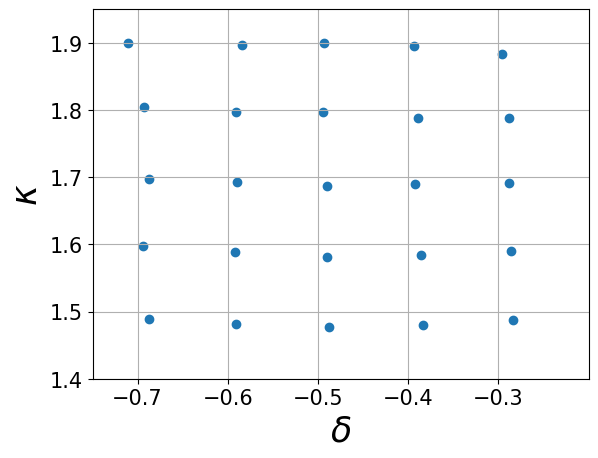

In [18]:
#OMFIT geometry calcs
plt.scatter(d_omfit, e_omfit)
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.75, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()